In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
ticker = 'META'
data = yf.download(ticker, period="5y")
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2019-08-05  184.690002  185.669998  179.339996  181.729996  181.357315   
2019-08-06  183.690002  185.789993  183.089996  184.509995  184.131607   
2019-08-07  183.600006  186.369995  181.220001  185.149994  184.770309   
2019-08-08  186.619995  190.339996  184.050003  190.160004  189.770035   
2019-08-09  190.000000  190.979996  187.119995  187.850006  187.464783   

              Volume  
Date                  
2019-08-05  23086700  
2019-08-06  18035700  
2019-08-07  15833200  
2019-08-08  14828900  
2019-08-09  11058800  


In [2]:
GPU_cuda_no = 0

cuda_no = 'cuda:'+str(GPU_cuda_no)

device = torch.device(cuda_no if torch.cuda.is_available() else 'cpu')

In [3]:
# model = net."MODLENAME"(num_features, output_size).to(device) #Make Modle

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
data['S_10'] = data['Close'].rolling(window=10).mean()
data['Corr'] = data['Close'].rolling(window=10).corr(data['S_10'])
data['Open-Close'] = data['Open'] - data['Close'].shift(1)
data['Open-Open'] = data['Open'] - data['Open'].shift(1)
data = data.dropna()
X_Log = data.iloc[:,:9]
y_Log = np.where(data['Close'].shift(-1) > data['Close'],1,-1)

In [5]:
split = int(0.7*len(data))
X_train_Log, X_test_Log, y_train_Log, y_test_Log = X_Log[:split], X_Log[split:], y_Log[:split], y_Log[split:]

In [6]:
model_Log = LogisticRegression()
model_Log = model_Log.fit (X_train_Log,y_train_Log)

In [7]:
coef_df = pd.DataFrame(zip(X_Log.columns, np.transpose(model_Log.coef_)))
print(coef_df)

            0                          1
0        Open   [5.5042141329028103e-05]
1        High   [5.5093953435354236e-05]
2         Low    [5.494473902644267e-05]
3       Close    [5.419762437146429e-05]
4   Adj Close    [5.408648543638214e-05]
5      Volume   [-2.009096551551531e-09]
6        S_10    [6.013793865602115e-05]
7        Corr  [-1.2176052784397424e-07]
8  Open-Close   [-1.412405286467848e-06]


In [8]:
probability = model_Log.predict_proba(X_test_Log)
predicted = model_Log.predict(X_test_Log)
print(predicted)

[-1 -1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1  1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

In [9]:
print(metrics.confusion_matrix(y_test_Log, predicted))
print(metrics.classification_report(y_test_Log, predicted))

[[  8 163]
 [ 13 188]]
              precision    recall  f1-score   support

          -1       0.38      0.05      0.08       171
           1       0.54      0.94      0.68       201

    accuracy                           0.53       372
   macro avg       0.46      0.49      0.38       372
weighted avg       0.46      0.53      0.41       372



In [10]:
train_loss = metrics.log_loss(y_train_Log, model_Log.predict_proba(X_train_Log))
test_loss = metrics.log_loss(y_test_Log, model_Log.predict_proba(X_test_Log))
train_accuracy = metrics.accuracy_score(y_train_Log, model_Log.predict(X_train_Log))
test_accuracy = metrics.accuracy_score(y_test_Log, predicted)

In [11]:
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {test_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy: {test_accuracy}")

Training Loss: 0.6927501693033524
Validation Loss: 0.6913826336495793
Training Accuracy: 0.5138248847926268
Validation Accuracy: 0.5268817204301075


In [12]:
data['Predicted_Signal'] = model_Log.predict(X_Log)
data['Meta_returns'] = np.log(data['Close'] / data['Close'].shift(1))
Cumulative_Meta_returns = np.cumsum(data[split:]['Meta_returns'])
data['Strategy_returns'] = data['Meta_returns'] * data['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(data[split:]['Strategy_returns'])

C:\Users\Jacob\AppData\Local\Temp\ipykernel_7976\3502862756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted_Signal'] = model_Log.predict(X_Log)
C:\Users\Jacob\AppData\Local\Temp\ipykernel_7976\3502862756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Meta_returns'] = np.log(data['Close'] / data['Close'].shift(1))
C:\Users\Jacob\AppData\Local\Temp\ipykernel_7976\3502862756.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

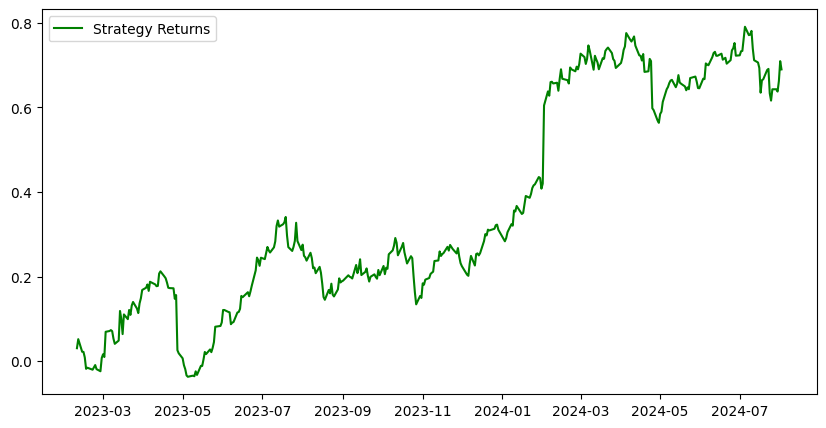

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(Cumulative_Strategy_returns, color='g', label='Strategy Returns')
plt.legend()
plt.show()